### Transformer Model

Transformer is an alternative to RNN models that can work without the sequencial structure of texts. Transformer model read the whole text input at once, unlike RNNs. Transformer model learns representation of each invidual words in a sentence and finally use the representation to model the language i.e. predict the next word.

Transformer model can be used as encoder as well as decoder. In the original paper "Attention Is All You Need" by Vaswani et al., they introduced transformer model as both encoder and decoder. 

<img src=https://cdn-images-1.medium.com/max/800/1*2vyKzFlzIHfSmOU_lnQE4A.png>


### Key components of transformer model

Original transformer paper introduced lots of novel concepts.

#### Positional Encoding

As transformers do not read text data sequentially, it is difficult to understand the relative position of each word in the text. The embedding vector for each word will learn the meaning, so now we need to input something that tells the network about the word’s position.

In positional encoding we learn a d-dimensional encoding scheme for each position of the input text using sinusodial functions. d is the word embedding size. (e.g. - 512 or 768 or 1024)

<img src=https://cdn-images-1.medium.com/max/800/1*yWGV9ck-0ltfV2wscUeo7Q.png>
<img src=https://cdn-images-1.medium.com/max/800/1*SgNlyFaHH8ljBbpCupDhSQ.png>

Positional encodings are added with the word embedding matrix.

<img src=https://miro.medium.com/max/2000/1*Y1MDr4WgzYp4eZaBOuJIYw.png>

In [1]:
%matplotlib inline

import os
import shutil
import json

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return pos_encoding

In [3]:
pos_encoding = positional_encoding(50, 128) #128 dimension of embedding, 50 max length of text
print (pos_encoding.shape)
print (pos_encoding)

(1, 50, 128)
[[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00 ...  1.00000000e+00
    0.00000000e+00  1.00000000e+00]
  [ 8.41470985e-01  5.40302306e-01  7.61720408e-01 ...  9.99999991e-01
    1.15478198e-04  9.99999993e-01]
  [ 9.09297427e-01 -4.16146837e-01  9.87046251e-01 ...  9.99999964e-01
    2.30956395e-04  9.99999973e-01]
  ...
  [ 1.23573123e-01 -9.92335469e-01  1.39920673e-01 ...  9.99980359e-01
    5.42744868e-03  9.99985271e-01]
  [-7.68254661e-01 -6.40144339e-01 -6.63571724e-01 ...  9.99979514e-01
    5.54292514e-03  9.99984638e-01]
  [-9.53752653e-01  3.00592544e-01 -9.99784705e-01 ...  9.99978652e-01
    5.65840153e-03  9.99983991e-01]]]


Text(0,0.5,'Position')

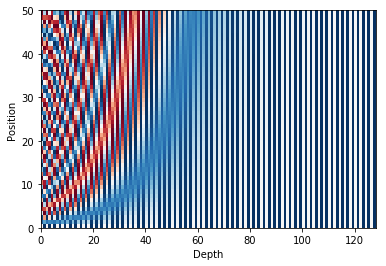

In [4]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')

#### Wordpiece/BPE tokenization

Tokenization is the technique to convert raw texts into some format that machine can understand. We often use word level or character level tokenization of texts. However, given huge corpus, word level tokenization may lead to too many words in the vocabulary which may not always be feasible. On the other hand, character level tokenization lacks interpretation. Character level tokenization also increases the sequence length drastically. That's why we need a better tokenization technique that can handle lots of words, subwords and even mispelled words.

BPE (BytePair Encoding) was originally used to help compress data by finding common byte pair combinations. BPE looks at most frequent subwords from words, merges them and does another iteration. 

WordPiece tokenization is also a similar concept built on subwords. Below is an example of wordpiece tokenization.

In [1]:
from transformers import AutoTokenizer, BertTokenizer

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',add_special_tokens=False) #'emilyalsentzer/Bio_ClinicalBERT'

In [6]:
print (tokenizer.vocab_size)

30522


In order to use transformer models, we need to use 2 special tokens "[CLS]" to denote start of the text and "[SEP]" to denote end of the text. Different models have different default special tokens. We can also avoid adding the 2 tokens manually. Using <b>add_special_token=True</b> in the tokenizer also, we can achieve the same thing.

In [7]:
sample_text = "[CLS] patient is diabetic and has a long history of smoking cigarette. patient had recently gone through surgery. [SEP]"
#print (tokenizer.tokenize(sample_text))
print (tokenizer.encode(sample_text,add_special_tokens=False))
print ([tokenizer.ids_to_tokens[i] for i in tokenizer.encode(sample_text,add_special_tokens=False)])
#print (tokenizer.decode(tokenizer.encode(sample_text,add_special_tokens=False)))

[101, 5776, 2003, 22939, 20915, 2594, 1998, 2038, 1037, 2146, 2381, 1997, 9422, 9907, 1012, 5776, 2018, 3728, 2908, 2083, 5970, 1012, 102]
['[CLS]', 'patient', 'is', 'dia', '##bet', '##ic', 'and', 'has', 'a', 'long', 'history', 'of', 'smoking', 'cigarette', '.', 'patient', 'had', 'recently', 'gone', 'through', 'surgery', '.', '[SEP]']


#### Attention Mask

As discussed earlier, transformer model uses the whole sentence at once. That's why it can not be used directly in decoder for text generation purpose. Attention mask is a technique to restrict the self attention in decoder blocks to look at subsequent words.

<img src=https://miro.medium.com/max/1000/1*4olcOVVPJp0648VVuD-HGg.png>

In [8]:
def subsequent_mask(size):
    attn_shape = (1,size,size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return subsequent_mask

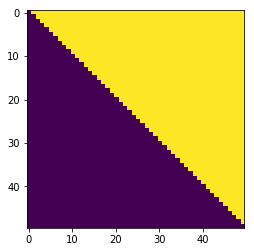

In [9]:
sample_mask = subsequent_mask(50) #50 max length of text
plt.imshow(sample_mask[0])

#### Multi-headed Self Attention

Ideally attention mechanism are between encoders and decoders. Self attention is applied on a single input sequence. So, same input sequence is used as <b>query</b>, <b>key</b> and <b>value</b>. The authors have shown that self attention can extract much better representation from text sequences. In Transformer <b>scaled dot-product attention</b> is used instead of Bahdanau attention.

<img src=https://cdn-images-1.medium.com/max/600/1*evdACdTOBT5j1g1nXialBg.png?>

<img src=https://cdn-images-1.medium.com/max/600/1*15E9qKg9bKnWdSRWCyY2iA.png>

With self-attention, attention weight for a text looks like 

<img src="https://miro.medium.com/max/1400/1*se1wlg03TiR3bYnyI8q9PA.png" width="550">

Each attention head converts representation of each word x into another representation z by applying the following operations.

<img src=https://miro.medium.com/max/2000/1*5rKwra-kv9DUpwGbZ-NYVA.png> <img src=https://miro.medium.com/max/1400/1*etLG-EqfKl5GcPxne9IQBQ.png>

Now multiple such attention heads are used to learn the representation. Finally they are concatenated together.

<img src=https://miro.medium.com/max/300/0*JVR9ZEXkq3LH5_c_.png>

#### Normalization

After multi-headed self attentions are concatenated, a <b>layer normalization</b> is applied. This improves stability of the model.

<img src=https://cdn-images-1.medium.com/max/800/1*4w3sQ14caDRkrQsAeK5Flw.png>


#### Residual Connection

A residual connection is basically just taking the input and adding it to the output of the sub-network, making training deep networks easier in the field of computer vision.

<img src=https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png>

### Use pretrained transformer based language model

Huggingface has recently open sourced a python library <b>transformers</b> that contains different transformer based language models pretrained. It also contains wrappers to run different transformer models on downstream application. We use pretrained BERT model to do exploration on sample clinical texts.

BERT (bidirectional encoder representation from transformers) is a model developed by Google in 2018. BERT is primarily an encoder, that's why it is not suitable for text generation task. During training, BERT uses masked language model (MLM) to predict words given the context. In BERT, 15% of the words from each sentences are either replaced with wrong words or, with a token "[MASK]". The primary objective of MLM is to predict the masked words.

<img src=https://miro.medium.com/max/1000/1*SOvSKfuipjXuwq94ukEYHw.png>

In the below section, we use BERT English base model which has 12 encoder layers, 12 self attention heads and 768 dimensional embedding for each token.

#### Exploring BERT model

In [10]:
from transformers import AutoModel, BertModel, GPT2Model, GPT2Tokenizer, AutoConfig, BertConfig, BertForMaskedLM
import torch

In [11]:
def plot_attentions(attentions,tokens, layer_num, attention_head_num):
    
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(attentions)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(tokens)))
    ax.set_yticks(np.arange(len(tokens)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(tokens)
    ax.set_yticklabels(tokens)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    #for i in range(len(tokens)):
    #    for j in range(len(tokens)):
    #        text = ax.text(j, i, "{0:.1f}".format(float(attentions[i, j])),
    #                       ha="center", va="center", color="w")
    
    ax.set_title("Attention at layer {} attention head {}".format(layer_num, attention_head_num))
    fig.tight_layout()
    plt.show()

In [12]:
config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True, output_attentions=True) #'emilyalsentzer/Bio_ClinicalBERT'
model = BertModel.from_pretrained('bert-base-uncased',config=config) #'emilyalsentzer/Bio_ClinicalBERT'

In [13]:
print (config)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_attentions": true,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



Let us apply BERT model on a sample text. First we need to tokenizer the text in wordpiece tokens and convert tokenized text into tensors (tensorflow or torch)

In [14]:
tokens = torch.LongTensor(np.asarray(tokenizer.encode(sample_text,add_special_tokens=False))[np.newaxis,:])
text_tokens = [tokenizer.ids_to_tokens[i] for i in tokenizer.encode(sample_text,add_special_tokens=False)]
model_out = model(tokens)

In [15]:
print (len(model_out))

4


BERT model generates total 4 outputs. 

1. 768 dimensional word embeddings for each of the tokens
2. 768 dimensional embeddings for the whole sentence (this is achieved by applying average pooling on the word embeddings)
3. 768 dimensional hidden states for each of the tokens
4. Attention weights between word tokens for each of 12 attention heads for each of 12 layers.

For downstream tasks, we need to use only the 1st item i.e. word embeddings and add necessary fine tuning layers.

In [16]:
model_out[0].shape

torch.Size([1, 23, 768])

In [17]:
model_out[0][0]

tensor([[-0.6668,  0.0810, -0.4755,  ..., -0.2706,  0.8885,  0.2839],
        [-0.8153, -0.7067, -0.1666,  ..., -0.2424,  1.1165,  0.4778],
        [-0.0460,  0.1225, -0.3355,  ..., -0.4453,  0.3439,  0.1198],
        ...,
        [-0.3647,  0.1469,  0.0242,  ..., -0.2644, -0.2317,  0.7063],
        [ 0.3134,  0.0586, -0.2933,  ...,  0.2223, -0.1873, -0.5682],
        [ 0.5359,  0.0690, -0.2596,  ...,  0.1219, -0.3832, -0.5245]],
       grad_fn=<SelectBackward>)

In [18]:
model_out[1].shape

torch.Size([1, 768])

In [19]:
len(model_out[2])

13

In [20]:
model_out[2][0].shape

torch.Size([1, 23, 768])

In [21]:
len(model_out[3])

12

In [22]:
model_out[3][0].shape

torch.Size([1, 12, 23, 23])

Let us visualize self attention for few of the attention heads. As discussed before, different attention heads learn different relationships between words within a text. During that process, the model learns better representation for each the words.

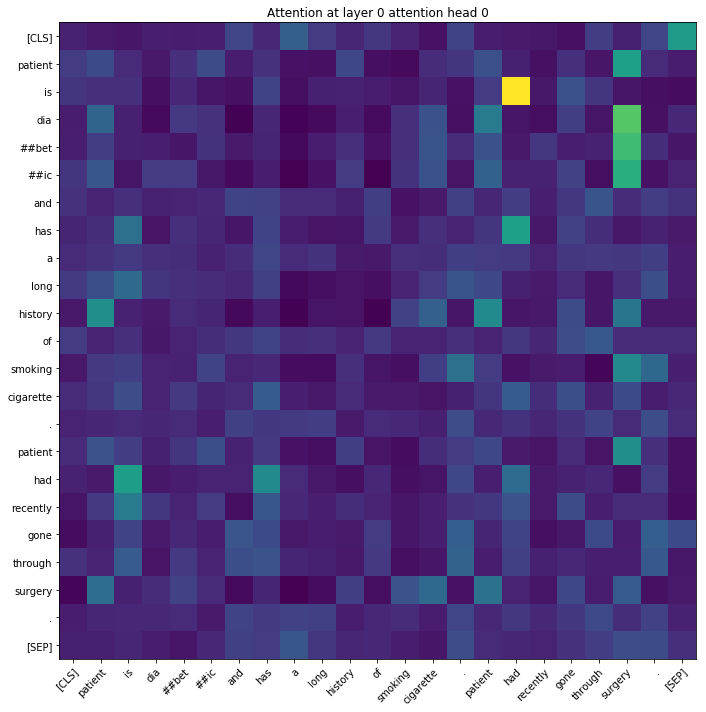

In [23]:
i = 0
j = 0
plot_attentions(model_out[3][i][0,j,:,:].detach().numpy(),text_tokens,i,j)

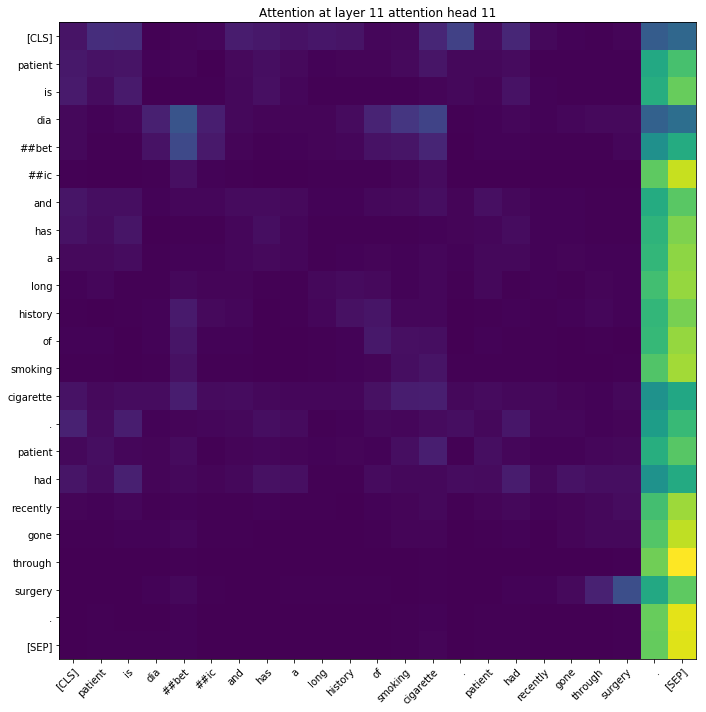

In [24]:
i = 11
j = 11
plot_attentions(model_out[3][i][0,j,:,:].detach().numpy(),text_tokens,i,j)

#### Predicting Masked Words using BERT

Next we use BERT masked model to predict masked word. We randomly mask 2 words in our text. Original BERT model is meant for inference and can not handle MASK token. That's why we use a different model <b>BertForMaskedLM</b> for this task.

In [25]:
sample_text_with_mask = "[CLS] patient is diabetic and has a long history of [MASK] cigarette. patient had recently gone through [MASK]. [SEP]"

In [26]:
print (tokenizer.encode(sample_text_with_mask,add_special_tokens=False))
print ([tokenizer.ids_to_tokens[i] for i in tokenizer.encode(sample_text_with_mask,add_special_tokens=False)])

[101, 5776, 2003, 22939, 20915, 2594, 1998, 2038, 1037, 2146, 2381, 1997, 103, 9907, 1012, 5776, 2018, 3728, 2908, 2083, 103, 1012, 102]
['[CLS]', 'patient', 'is', 'dia', '##bet', '##ic', 'and', 'has', 'a', 'long', 'history', 'of', '[MASK]', 'cigarette', '.', 'patient', 'had', 'recently', 'gone', 'through', '[MASK]', '.', '[SEP]']


In [27]:
tokens = torch.LongTensor(np.asarray(tokenizer.encode(sample_text_with_mask,add_special_tokens=False))[np.newaxis,:])
masked_model = BertForMaskedLM.from_pretrained('bert-base-uncased',config=config)
model_out = masked_model(tokens)

In [28]:
mask_indices = np.where(tokens[0].numpy() == tokenizer.mask_token_id)[0]
print (mask_indices)

predicted_indices = np.argmax(np.asarray(model_out[0][0].detach().numpy())[mask_indices,:] ,axis=1)
predicted_words_decoded = tokenizer.decode(predicted_indices)

text = " ".join([tokenizer.ids_to_tokens[i] for i in tokenizer.encode(sample_text_with_mask,add_special_tokens=False)])

print ("Predicted sentence -")
print (text.replace("[CLS]","").replace("[SEP]","").replace("[MASK]",predicted_words_decoded).strip())

[12 20]
Predicted sentence -
patient is dia ##bet ##ic and has a long history of smoking surgery cigarette . patient had recently gone through smoking surgery .


Both the words are predicted correctly!! Next we see all top 10 words for each of the MASKs.

In [29]:
n_top=10
for mask_indice in mask_indices:
    top_10_indices = np.argsort(np.asarray(model_out[0][0].detach().numpy())[[mask_indice],:], axis=1)[0,-n_top:]
    top_10_words = tokenizer.decode(top_10_indices).split()
    top_10_words.reverse()

    print ("Top 10 predicted words")
    print (top_10_words)

Top 10 predicted words
['smoking', 'using', 'taking', 'a', 'smoke', 'burning', 'smoked', 'drinking', 'consuming', 'carrying']
Top 10 predicted words
['surgery', 'chemotherapy', 'depression', 'withdrawal', 'cancer', 'treatment', 'therapy', 'rehab', 'drugs', 'diabetes']


Top 10 predicted words are very relevant!!

#### GPT2 model for text generation

As discussed previously, BERT model is not auto regressive and hence can not be used for text generation. GPT2 model is widely popular for text generation purpose. GPT2 model, developed by OpenAI uses transformer architecuture and was trained on huge Wikipedia corpus. GPT2 is a decoder based model where masked self attention is used in decoder.

Next we explore GPT2 model for text generation. We provide a sample text to the model and generate some additional text.

In [30]:
from transformers import GPT2Config, GPT2Tokenizer, GPT2LMHeadModel

In [31]:
gpt_tokenizer = GPT2Tokenizer.from_pretrained("gpt2",add_special_tokens=False,mask_token='[MASK]',cls_token='[CLS]',sep_token='[SEP]')
gpt_model = model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

ERROR:transformers.tokenization_utils:Using eos_token, but it is not set yet.


In [32]:
#input_ids = gpt_tokenizer.encode(sample_text)
sample_text = "patient is diabetic"
tokens = torch.LongTensor(np.asarray(gpt_tokenizer.encode(sample_text,add_special_tokens=False))[np.newaxis,:])

# generate text until the output length (which includes the context length) reaches 50
greedy_output = gpt_model.generate(tokens, max_length=30)

print("Output:\n" + 100 * '-')
print(gpt_tokenizer.decode(greedy_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
patient is diabetic.

The study was published in the journal Diabetes Care.

The study was funded by the National Institutes of Health.



In text generation, different kinds of sampling techniques are used.

* Beam search
* Top k sampling
* Top p (Nucleus) sampling

<img src=https://huggingface.co/blog/assets/02_how-to-generate/beam_search.png>

In [33]:
beam_output = gpt_model.generate(
    tokens, 
    max_length=30, 
    num_beams=5
)

print("Output:\n" + 100 * '-')
print(gpt_tokenizer.decode(beam_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
patient is diabetic.

If you have diabetes, you may be at increased risk for complications such as:

diabetes mellitus




### Use pretrained language model in downstream tasks

Below we show how BERT or, any transformer models be used for finetuning solving downstream tasks. Transformer models need 3 inputs.

1. Tokenized text input
2. Attention masks - masks are 1 for visible words and 0 for padding or, masked words
3. Input segments - BERT can take multiple sentences as input. Each sentence is denotes with unique segment ids.

In [34]:
def _convert_to_transformer_inputs(text, tokenizer, max_sequence_length):
    """Converts tokenized input to ids, masks and segments for transformer (including bert)"""
    
    def return_id(str1, str2, truncation_strategy, length):

        inputs = tokenizer.encode_plus(str1, str2,
            add_special_tokens=True,
            max_length=length,
            truncation_strategy=truncation_strategy)
        
        input_ids =  inputs["input_ids"]
        input_masks = [1] * len(input_ids)
        input_segments = inputs["token_type_ids"]
        padding_length = length - len(input_ids)
        padding_id = tokenizer.pad_token_id
        input_ids = input_ids + ([padding_id] * padding_length)
        input_masks = input_masks + ([0] * padding_length)
        input_segments = input_segments + ([0] * padding_length)
        
        return [input_ids, input_masks, input_segments]
    
    input_ids, input_masks, input_segments = return_id(
        text, None, 'longest_first', max_sequence_length)
    
    return [input_ids, input_masks, input_segments]

def compute_input_arrays(texts, tokenizer, max_sequence_length):
    input_ids, input_masks, input_segments = [], [], []
    for text in tqdm(texts):

        ids, masks, segments = \
        _convert_to_transformer_inputs(text, tokenizer, max_sequence_length)
        
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)
        
    return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]

In [35]:
input_ids, input_masks, input_segments = compute_input_arrays([sample_text],tokenizer,max_sequence_length=50)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.66it/s]


In [36]:
input_ids, input_masks, input_segments

(array([[  101,  5776,  2003, 22939, 20915,  2594,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]]),
 array([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]]))

Below we show a sample keras model containing BERT basemodel for binary classification.

In [37]:
import tensorflow as tf
from transformers import TFBertModel

In [38]:
def create_model(MAX_SEQUENCE_LENGTH=50):
    id = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    atn = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True, output_attentions=True) # print(config) to see settings

    bert_model = TFBertModel.from_pretrained('bert-base-uncased',config=config) #''
    
    # if config.output_hidden_states = True, obtain hidden states via bert_model(...)[-1]
    embedding = bert_model(id, attention_mask=mask, token_type_ids=atn)[0]
    
    x = tf.keras.layers.GlobalAveragePooling1D()(embedding)
    
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=[id, mask, atn], outputs=x)
    
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model

In [39]:
finetune_model = create_model()
finetune_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 50, 768), (N 109482240   input_1[0][0]                    
______________________________________________________________________________________________

#### Model without Bert layer training

In [40]:
bert_layer = finetune_model.layers[3]
bert_layer.trainable = False

In [41]:
finetune_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 50, 768), (N 109482240   input_1[0][0]                    
______________________________________________________________________________________________

### Learn own transformer language model

We can also learn our own BERT model on custom dataset. Huggingface has recently published an article showing the steps to generate own BERT model. Below are the steps for learning any new BERT model.

1. Learn own BytePair or Wordpiece tokenization on custom dataset
2. Run Language model on custom dataset

In [42]:
data_df = pd.read_csv('./clinical_notes_cleaned.csv')
data_df.head(5)

,text,label,clean_text
0,\n \n \n \n \n <B>CC:</B> Difficulty with word...,Neurology,difficulty word find . 27y / rhf experience su...
1,\n \n \n \n \n <B>PREOPERATIVE DIAGNOSIS: </B>...,Orthopedic,preoperative ganglion left wrist . postoperati...
2,\n \n \n \n \n <B>PREOPERATIVE DIAGNOSIS: </B>...,Orthopedic,"preoperative cervical myelopathy , c3 - 4 , se..."
3,\n \n \n \n \n <B>EXAM:</B>MRI LEFT SHOULDER\n...,Radiology,mri leave shoulder 69-year - old male pain sho...
4,\n \n \n \n \n <B>HISTORY OF PRESENT ILLNESS: ...,Orthopedic,history present patient 57-year - old female s...


In [43]:
data_df[['clean_text']].to_csv('./clinical_texts.txt',index=False,header=False)

In [44]:
paths = ["./clinical_texts.txt"]

In [45]:
from tokenizers import ByteLevelBPETokenizer, BertWordPieceTokenizer
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

In [46]:
"""
bpe_tokenizer = ByteLevelBPETokenizer()

bpe_tokenizer.train(files=paths, vocab_size=10000, min_frequency=3, special_tokens=[
    "[CLS]",
    "[PAD]",
    "[SEP]",
    "[UNK]",
    "[MASK]",
])

# Save files to disk
bpe_tokenizer.save(".", "healthbert")
"""

'\nbpe_tokenizer = ByteLevelBPETokenizer()\n\nbpe_tokenizer.train(files=paths, vocab_size=10000, min_frequency=3, special_tokens=[\n    "[CLS]",\n    "[PAD]",\n    "[SEP]",\n    "[UNK]",\n    "[MASK]",\n])\n\n# Save files to disk\nbpe_tokenizer.save(".", "healthbert")\n'

#### Learn custom wordpiece tokenizer

In [47]:
tokenizer = BertWordPieceTokenizer(
    vocab_file=None,
    unk_token='[UNK]',
    sep_token='[SEP]',
    cls_token='[CLS]',
    clean_text=True,
    handle_chinese_chars=True,
    strip_accents=True,
    lowercase=True,
    wordpieces_prefix='##'
)#SentencePieceBPETokenizer()

# Customize training
tokenizer.train(files='./clinical_texts.txt', vocab_size=10000, min_frequency=3, limit_alphabet=1000,
    special_tokens=['[PAD]', '[UNK]', '[CLS]', '[MASK]', '[SEP]'])

tokenizer.save(directory='./',name='healthbert')

['./healthbert-vocab.txt']

In [49]:
os.makedirs('./HealthBERT/')

In [50]:
shutil.copy2('./healthbert-vocab.txt','./HealthBERT/vocab.txt')

'./HealthBERT/vocab.txt'

In [51]:
sample_text = "patient is diabetic and has a long history of smoking cigarette. patient had recently gone through surgery."

In [52]:
'''
bpe_tokenizer = ByteLevelBPETokenizer(
    "./healthbert-vocab.json",
    "./healthbert-merges.txt",
)
bpe_tokenizer._tokenizer.post_processor = BertProcessing(
    ("[SEP]", bpe_tokenizer.token_to_id("[SEP]")),
    ("[CLS]", bpe_tokenizer.token_to_id("[CLS]")),
)
bpe_tokenizer.enable_truncation(max_length=100)

bpe_tokens = bpe_tokenizer.encode(sample_text)
print(bpe_tokens.tokens)
print(bpe_tokens.ids)
#print ([bpe_tokenizer.ids_to_tokens[i] for i in bpe_tokenizer.encode(sample_text)])
'''

'\nbpe_tokenizer = ByteLevelBPETokenizer(\n    "./healthbert-vocab.json",\n    "./healthbert-merges.txt",\n)\nbpe_tokenizer._tokenizer.post_processor = BertProcessing(\n    ("[SEP]", bpe_tokenizer.token_to_id("[SEP]")),\n    ("[CLS]", bpe_tokenizer.token_to_id("[CLS]")),\n)\nbpe_tokenizer.enable_truncation(max_length=100)\n\nbpe_tokens = bpe_tokenizer.encode(sample_text)\nprint(bpe_tokens.tokens)\nprint(bpe_tokens.ids)\n#print ([bpe_tokenizer.ids_to_tokens[i] for i in bpe_tokenizer.encode(sample_text)])\n'

In [53]:
tokenizer = BertTokenizer.from_pretrained('./HealthBERT/vocab.txt',add_special_tokens=True)
print (tokenizer.encode(sample_text,add_special_tokens=False))
print ([tokenizer.ids_to_tokens[i] for i in tokenizer.encode(sample_text,add_special_tokens=False)])

[137, 1612, 5462, 3194, 3505, 64, 32, 696, 353, 1749, 3863, 3438, 14, 137, 3505, 80, 2664, 8466, 65, 837, 719, 14]
['patient', 'is', 'diabetic', 'and', 'ha', '##s', 'a', 'long', 'history', 'of', 'smoking', 'cigarette', '.', 'patient', 'ha', '##d', 'recently', 'gon', '##e', 'through', 'surgery', '.']


#### Learn custom BERT model for masked language model

First we need to fix the model configurations e.g. - number of layers, number of attention heads, embedding dimension etc.

However, learning a good model requires vast amount of data and huge computational resource.

In [54]:
config = {
    "architectures": [
    "BertForMaskedLM"
    ],
    "attention_probs_dropout_prob": 0.1,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "hidden_size": 768,
    "initializer_range": 0.02,
    "intermediate_size": 3072,
    "layer_norm_eps": 1e-05,
    "max_position_embeddings": 514,
    "model_type": "bert",
    "num_attention_heads": 12,
    "num_hidden_layers": 6,
    "type_vocab_size": 1,
    "vocab_size": 10000
}
with open("./HealthBERT/config.json", 'w') as fp:
    json.dump(config, fp)

tokenizer_config = {
    "max_len": 100
}
with open("./HealthBERT/tokenizer_config.json", 'w') as fp:
    json.dump(tokenizer_config, fp)

In [55]:
'''
!python run_language_modeling.py \
--train_data_file ./clinical_texts.txt \
--output_dir ./HealthBERT-small/ \
--model_type bert \
--mlm \
--config_name ./HealthBERT \
--tokenizer_name ./HealthBERT \
--do_train \
--line_by_line \
--learning_rate 1e-4 \
--num_train_epochs 2 \
--save_total_limit 2 \
--save_steps 2000 \
--seed 42
'''

'\n!python run_language_modeling.py --train_data_file ./clinical_texts.txt --output_dir ./HealthBERT-small/ --model_type bert --mlm --config_name ./HealthBERT --tokenizer_name ./HealthBERT --do_train --line_by_line --learning_rate 1e-4 --num_train_epochs 2 --save_total_limit 2 --save_steps 2000 --seed 42\n'

In [56]:
#model = BertModel.from_pretrained('./HealthBERT-small')

### Downstream application of transformer based language model (Inference only)

Huggingface transformer library has a pipeline feature that can be used directly for inference without any further processing. Currently it supports below downstream tasks - 

* Sentiment analysis
* NER
* Sequence classification
* Extractive Question Answering - extracts start index and end index of the answer from the reference text given a question
* Mask filling
* Text generation
* Abstractive Summarization - generates summarization based on a given long text

Below we demonstrate text summarization and QA performed on sample texts.

In [57]:
from transformers import pipeline

#### Text Summarization

Text summarizations can be - abstractive or, extractive. Extractive summarization extracts important segments from a text which can be put into summary. Abstractive summarization on the other hand is much harder task and requires sequence to sequence modelling.

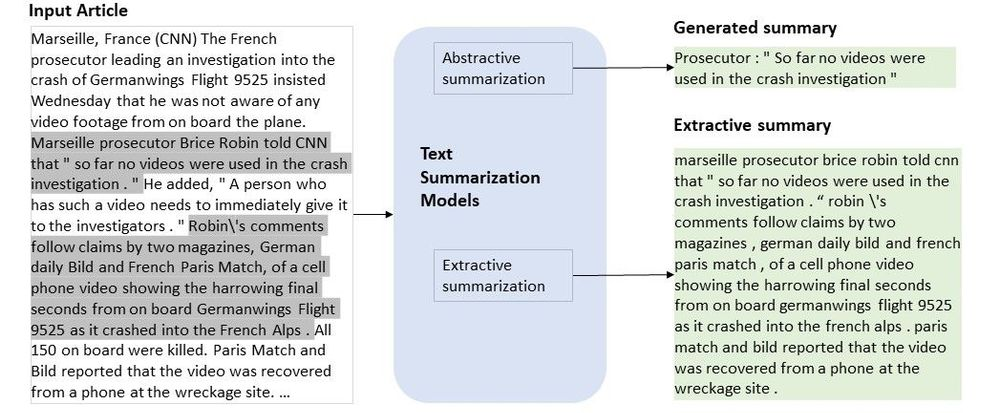

We use a long text on Covid 19 and generate summary text.

In [75]:
summarizer = pipeline("summarization")

In [81]:
raw_text = """introduction an epidemic of coronavirus disease 2019 (covid-19) began in december 2019 in china leading to a public health emergency of international concern (pheic). clinical, laboratory, and imaging features have been partially characterized in some observational studies. no systematic reviews on covid-19 have been published to date. methods we performed a systematic literature review with meta-analysis, using three databases to assess clinical, laboratory, imaging features, and outcomes of covid-19 confirmed cases. observational studies and also case reports, were included, and analyzed separately. we performed a random-effects model meta-analysis to calculate the pooled prevalence and 95% confidence interval (95%ci). results 660 articles were retrieved for the time frame (1/1/2020-2/23/2020). after screening, 27 articles were selected for full-text assessment, 19 being finally included for qualitative and quantitative analyses. additionally, 39 case report articles were included and analyzed separately. for 656 patients, fever (88.7%, 95%ci 84.5–92.9%), cough (57.6%, 40.8–74.4%) and dyspnea (45.6%, 10.9–80.4%) were the most prevalent manifestations. among the patients, 20.3% (95%ci 10.0–30.6%) required intensive care unit (icu), 32.8% presented with acute respiratory distress syndrome (ards) (95%ci 13.7–51.8), 6.2% (95%ci 3.1–9.3) with shock. some 13.9% (95%ci 6.2–21.5%) of hospitalized patients had fatal outcomes (case fatality rate, cfr). conclusion covid-19 brings a huge burden to healthcare facilities, especially in patients with comorbidities. icu was required for approximately 20% of polymorbid, covid-19 infected patients and hospitalization was associated with a cfr of over 13%. as this virus spreads globally, countries need to urgently prepare human resources, infrastructure and facilities to treat severe covid-19."""

In [82]:
#raw_text = data_df.clean_text.iloc[0]
print (raw_text)

introduction an epidemic of coronavirus disease 2019 (covid-19) began in december 2019 in china leading to a public health emergency of international concern (pheic). clinical, laboratory, and imaging features have been partially characterized in some observational studies. no systematic reviews on covid-19 have been published to date. methods we performed a systematic literature review with meta-analysis, using three databases to assess clinical, laboratory, imaging features, and outcomes of covid-19 confirmed cases. observational studies and also case reports, were included, and analyzed separately. we performed a random-effects model meta-analysis to calculate the pooled prevalence and 95% confidence interval (95%ci). results 660 articles were retrieved for the time frame (1/1/2020-2/23/2020). after screening, 27 articles were selected for full-text assessment, 19 being finally included for qualitative and quantitative analyses. additionally, 39 case report articles were included an

In [83]:
summary = summarizer(raw_text, min_length=30,max_length=130)
summary = summary[0]["summary_text"]
print (summary)

 coronavirus disease 2019 (covid-19) began in december 2019 in china leading to a public health emergency of international concern (pheic) clinical, laboratory, and imaging features have been partially characterized in some observational studies. We performed a systematic literature review with meta-analysis, using three databases to assess clinical, lab, imaging features, and outcomes of confirmed cases.


In [84]:
raw_text = """ the outbreak of coronavirus disease 2019 (covid-19) has become a public health emergency of major international concern. given the systemic immunosuppressive state caused by malignancy and anticancer treatments, patients with advanced lung cancer may be at a higher risk of covid-19 infection. during epidemic of covid-19, a guideline for the optimal management of patients with advanced lung cancer urgently needs to be proposed to distinguish the symptoms of covid-19 and the side effects of antitumor drugs. this network questionnaire survey was conducted on the lung cancer group of the chinese thoracic society, chinese medical association; the lung cancer group of the chinese society of clinical oncology youth committee; and the chinese respiratory oncology collaboration. 321 valid questionnaires were received. based on the guidelines on lung cancer and the results of the questionnaires, a consensus was reached. during the epidemic of covid-19, we recommended that patients with advanced nsclc should be treated as outpatients as possible at the nearest medical center; patients who need to be hospitalized for antitumor treatment should be excluded from covid-19 infection; more intensive attention should be paid to identification of covid-19-related symptoms and adverse reactions caused by the malignancy or antitumor treatments. stronger personal protection should be made for advanced nsclc patients; an intentional postponing of antitumor treatment should be considered according to patient performance status. treatment strategies should be made according to different types of advanced nsclc patients and efficacy and toxicity of drugs. """
print (raw_text)

 the outbreak of coronavirus disease 2019 (covid-19) has become a public health emergency of major international concern. given the systemic immunosuppressive state caused by malignancy and anticancer treatments, patients with advanced lung cancer may be at a higher risk of covid-19 infection. during epidemic of covid-19, a guideline for the optimal management of patients with advanced lung cancer urgently needs to be proposed to distinguish the symptoms of covid-19 and the side effects of antitumor drugs. this network questionnaire survey was conducted on the lung cancer group of the chinese thoracic society, chinese medical association; the lung cancer group of the chinese society of clinical oncology youth committee; and the chinese respiratory oncology collaboration. 321 valid questionnaires were received. based on the guidelines on lung cancer and the results of the questionnaires, a consensus was reached. during the epidemic of covid-19, we recommended that patients with advanced

In [85]:
summary = summarizer(raw_text, min_length=30,max_length=130)
summary = summary[0]["summary_text"]
print (summary)

The outbreak of coronavirus disease 2019 (covid-19) has become a public health emergency of major international concern. given the systemic immunosuppressive state caused by malignancy and anticancer treatments, patients with advanced lung cancer may be at a higher risk of infection. A guideline for the optimal management of patients with lung cancer urgently needs to be proposed.


#### Question-Answering

BERT model can perform extractive question answering. Given a reference text and a question, it can predict the token index of the starting token and end token. All text falling in between is the answer.

<img src=https://miro.medium.com/max/1840/1*QhIXsDBEnANLXMA0yONxxA.png>

In [86]:
qa = pipeline("question-answering")

In [90]:
raw_text = """ the outbreak of coronavirus disease 2019 (covid-19) has become a public health emergency of major international concern. given the systemic immunosuppressive state caused by malignancy and anticancer treatments, patients with advanced lung cancer may be at a higher risk of covid-19 infection. during epidemic of covid-19, a guideline for the optimal management of patients with advanced lung cancer urgently needs to be proposed to distinguish the symptoms of covid-19 and the side effects of antitumor drugs. this network questionnaire survey was conducted on the lung cancer group of the chinese thoracic society, chinese medical association; the lung cancer group of the chinese society of clinical oncology youth committee; and the chinese respiratory oncology collaboration. 321 valid questionnaires were received. based on the guidelines on lung cancer and the results of the questionnaires, a consensus was reached. during the epidemic of covid-19, we recommended that patients with advanced nsclc should be treated as outpatients as possible at the nearest medical center; patients who need to be hospitalized for antitumor treatment should be excluded from covid-19 infection; more intensive attention should be paid to identification of covid-19-related symptoms and adverse reactions caused by the malignancy or antitumor treatments. stronger personal protection should be made for advanced nsclc patients; an intentional postponing of antitumor treatment should be considered according to patient performance status. treatment strategies should be made according to different types of advanced nsclc patients and efficacy and toxicity of drugs. """
print (raw_text)

 the outbreak of coronavirus disease 2019 (covid-19) has become a public health emergency of major international concern. given the systemic immunosuppressive state caused by malignancy and anticancer treatments, patients with advanced lung cancer may be at a higher risk of covid-19 infection. during epidemic of covid-19, a guideline for the optimal management of patients with advanced lung cancer urgently needs to be proposed to distinguish the symptoms of covid-19 and the side effects of antitumor drugs. this network questionnaire survey was conducted on the lung cancer group of the chinese thoracic society, chinese medical association; the lung cancer group of the chinese society of clinical oncology youth committee; and the chinese respiratory oncology collaboration. 321 valid questionnaires were received. based on the guidelines on lung cancer and the results of the questionnaires, a consensus was reached. during the epidemic of covid-19, we recommended that patients with advanced

In [87]:
print(qa(question="When did coronavirus outbreak happen?", context=raw_text))

{'score': 0.9827142383767011, 'start': 37, 'end': 41, 'answer': '2019'}


In [88]:
print(qa(question="Who are at highest risks of covid-19 infection?", context=raw_text))

{'score': 0.8303126868707942, 'start': 213, 'end': 247, 'answer': 'patients with advanced lung cancer'}


In [89]:
print(qa(question="What actions should be made for the patients?", context=raw_text))

{'score': 0.3548476209089415, 'start': 1531, 'end': 1551, 'answer': 'treatment strategies'}


In [91]:
raw_text = """introduction an epidemic of coronavirus disease 2019 (covid-19) began in december 2019 in china leading to a public health emergency of international concern (pheic). clinical, laboratory, and imaging features have been partially characterized in some observational studies. no systematic reviews on covid-19 have been published to date. methods we performed a systematic literature review with meta-analysis, using three databases to assess clinical, laboratory, imaging features, and outcomes of covid-19 confirmed cases. observational studies and also case reports, were included, and analyzed separately. we performed a random-effects model meta-analysis to calculate the pooled prevalence and 95% confidence interval (95%ci). results 660 articles were retrieved for the time frame (1/1/2020-2/23/2020). after screening, 27 articles were selected for full-text assessment, 19 being finally included for qualitative and quantitative analyses. additionally, 39 case report articles were included and analyzed separately. for 656 patients, fever (88.7%, 95%ci 84.5–92.9%), cough (57.6%, 40.8–74.4%) and dyspnea (45.6%, 10.9–80.4%) were the most prevalent manifestations. among the patients, 20.3% (95%ci 10.0–30.6%) required intensive care unit (icu), 32.8% presented with acute respiratory distress syndrome (ards) (95%ci 13.7–51.8), 6.2% (95%ci 3.1–9.3) with shock. some 13.9% (95%ci 6.2–21.5%) of hospitalized patients had fatal outcomes (case fatality rate, cfr). conclusion covid-19 brings a huge burden to healthcare facilities, especially in patients with comorbidities. icu was required for approximately 20% of polymorbid, covid-19 infected patients and hospitalization was associated with a cfr of over 13%. as this virus spreads globally, countries need to urgently prepare human resources, infrastructure and facilities to treat severe covid-19."""
print (raw_text)

introduction an epidemic of coronavirus disease 2019 (covid-19) began in december 2019 in china leading to a public health emergency of international concern (pheic). clinical, laboratory, and imaging features have been partially characterized in some observational studies. no systematic reviews on covid-19 have been published to date. methods we performed a systematic literature review with meta-analysis, using three databases to assess clinical, laboratory, imaging features, and outcomes of covid-19 confirmed cases. observational studies and also case reports, were included, and analyzed separately. we performed a random-effects model meta-analysis to calculate the pooled prevalence and 95% confidence interval (95%ci). results 660 articles were retrieved for the time frame (1/1/2020-2/23/2020). after screening, 27 articles were selected for full-text assessment, 19 being finally included for qualitative and quantitative analyses. additionally, 39 case report articles were included an

In [93]:
print(qa(question="What are the prevalent manifestations?", context=raw_text))

{'score': 0.05835282575776368, 'start': 1104, 'end': 1111, 'answer': 'dyspnea'}


In [94]:
print(qa(question="Which databases are used to assess the outcomes of covid-19?", context=raw_text))

{'score': 0.41587701758869855, 'start': 416, 'end': 431, 'answer': 'three databases'}


### References

1. https://towardsdatascience.com/from-pre-trained-word-embeddings-to-pre-trained-language-models-focus-on-bert-343815627598
2. https://blog.floydhub.com/gpt2/
3. http://jalammar.github.io/illustrated-gpt2/
4. https://blog.floydhub.com/the-transformer-in-pytorch/
5. https://huggingface.co/blog/how-to-generate
6. https://huggingface.co/blog/how-to-train
7. https://huggingface.co/transformers/usage.html
8. https://github.com/harvardnlp/annotated-transformer/blob/master/The%20Annotated%20Transformer.ipynb